<a href="https://colab.research.google.com/github/suy379/do_it_DL_intro/blob/main/06_%EB%8B%A4%EC%B8%B5_%EC%8B%A0%EA%B2%BD%EB%A7%9D(%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98)%2B%EA%B2%BD%EC%82%AC%ED%95%98%EA%B0%95%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 06-1. 배치 경사 하강법
- 지금까지 구현한 SingleLayer는 확률적 경사 하강법을 구현하였다. 이번엔 가중치 1번 업데이트마다 전체 샘플을 사용하는 배치 경사 하강법을 구현해보자.
- 지금까지는 샘플 각각에 대해 가중치 1번 업데이트(z 계산 시, 스칼라 곱)를 했으나 이번엔 z 계산 시 x데이터 전체*w행렬을 곱해서 구함.(행렬 곱)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터 가져오기(sklearn 위스콘신 유방암 데이터 세트)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
print(x.shape, y.shape)

(569, 30) (569,)


In [ ]:
# 데이터 나누기
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [ ]:
#앞서 확률적 경사 하강법용으로 만든 클래스 보완 --> 배치 경사 하강법으로 수정!
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0): 
        self.w = None
        self.b = None
        self.losses = [] #epoch별 rain set의 loss
        self.val_losses = [] #epoch별 val set의 loss
        self.w_history= [] 
        self.lr = learning_rate 
        self.l1 = l1 #l1규제의 alpha
        self.l2 = l2 #l2규제의 alpha 값 
    
    # 정방향 계산 메서드(z를 출력) --> 수정!(행렬 계산) 
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b #z(364,1) = x(364,30)*w(30,1)+b(364,1)
        return z

    # 정방향 메서드(a를 출력)
    def activation(self, z):
        a = 1 / (1+np.exp(-z))
        return a 

    # 역방향 계산(그레디언트를 출력) --> 수정!(이번엔 x를 전체샘플을 사용하므로 w_grad는 평균값을 출력해준다.)
    def backprop(self, x, err):
        m = len(x) #x의 개수 
        w_grad = np.dot(x.T, err)/m 
        b_grad = np.sum(err)/m
        return w_grad, b_grad 

    # 로지스틱 손실 함수에 패널티 항 더하기-> fit 메서드에 적용 
    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

    # 검증셋의 loss값 계산 
    def update_val_loss(self, x_val, y_val):
        if x_val is None: 
            return
        #train set에서와 동일하게 접근해가면 됨.
        z = self.forpass(x_val)
        a = self.activation(z)
        #loss값 계산
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        #val_loss 평균값 반환 
        self.val_losses.append((val_loss + self.reg_loss())/len(y_val))


    # 핵심: 학습 메서드 --> 이 안엔 train셋(x_train, y_train)만 넣기.
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): 
        #타깃을 열벡터로 바꾸기(계산 편의를 위해)
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1)
        m = len(x)
        #초기값 설정
        self.w = np.ones((x.shape[1],1)) #w: (30x1)
        self.b = 0
        self.w_history.append(self.w.copy()) 
        #epochs만큼 반복(인덱스 반복문 삭제!!)
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y-a)
            w_grad, b_grad = self.backprop(x, err) #backprop메서드에 의해 그레디언트 평균값 적용됨.
            #규제 적용
            w_grad += (self.l1*np.sign(self.w) + self.l2*self.w)/m #평균값 적용 
            #업데이트
            self.w -= self.lr*w_grad
            self.b -= self.lr*b_grad 
            #가중치 기록
            self.w_history.append(self.w.copy())
            #train_loss 계산 
            a = np.clip(a, 1e-10, 1-1e-10) 
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #이제는 epoch한번 수행후 self.losses에 바로 넣을수 있다.
            self.losses.append((loss + self.reg_loss())/m) #loss도 평균값 반환 
            #val_loss 계산
            self.update_val_loss(x_val, y_val)


    # 핵심: 예측 메서드-- 이 안에는 x_test만 넣는다.
    def predict(self, x):
        z = self.forpass(x)
        return z >0 
    
    # 평가 메서드-- 이 안에는 앞서 predict로 반환된 값과 y_test를 비교한 정확도를 출력.
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1,1)) #타겟 열벡터 반환 


In [ ]:
#훈련셋을 표준화 전처리하여 SingleLayer 클래스 학습
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
#표준화 적용 
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
#배치 경사 하강법 적용
layer1 = SingleLayer(l2=0.01)
layer1.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000) #배치 경사하강법 쓸 땐 에폭을 늘려주는게 좋다!
layer1.score(x_val_scaled, y_val)

0.978021978021978

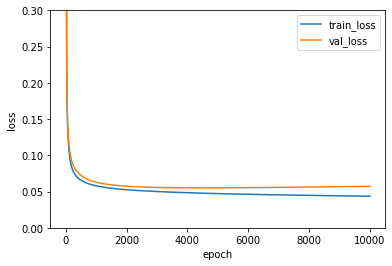

In [ ]:
#훈련셋과 검증셋 loss 비교
plt.plot(layer1.losses) #train_loss
plt.plot(layer1.val_losses) #val_loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,0.3)
plt.legend(['train_loss','val_loss'])
plt.show()

- 확률적 경사 하강법에 비해 변동이 심하지 않고 안정적으로 loss의 최적값(최소값)을 찾는다.
- 그 이유는 밑의 가중치 변화 그래프를 그려보면 더 잘 이해 가능!

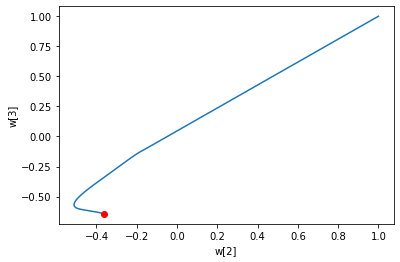

In [ ]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

- 최적의 가중치를 찾아나가는 데 부드럽게 안정적으로 찾는다. 앞서 확률적 경사 하강법은 엄청 지그재그거렸는데 배치는 그닥 얼마 이동하지 않고 최적값을 바로 찾았다. 
- 이렇게 __배치는 안정적으로 최적값을 찾을 수 있다는 장점이 있지만, 매번 전체 훈련셋을 사용하므로 연산비용이 많이 들고 최솟값에 수렴하는 데 시간이 오래 걸린다는 단점이 있다.__

## 06-2. 2개의 층을 가진 다층 신경망 구현(배치 경사 하강법)
- 2개의 층이 있다 = 은닉층 1개가 새로 생겼다!
- 은닉층의 뉴런 개수를 여러개로 늘려본다.(디폴트는 10->self.unit=10)
- __은닉층의 계산에서 사용되는 가중치(w1(피처개수x은닉층뉴런수)),절편(b1(1x은닉층뉴런수))__
- __출력층의 계산에서 사용되는 가중치(w2(은닉층뉴런수x출력층뉴런수:여기선1)),절편(b2(1x출력층뉴런수:1))__
- 무조건 행렬 연산한다는거 기억!!!!!!!

In [ ]:
#앞서 구현한 SingleLayer에서 다 비슷한데 은닉층 부분이 들어감으로써 정방향, 역방향 계산을 수정해야 함.
#SingleLayer를 상속받아 필요한 부분만 수정 
class DualLayer(SingleLayer):
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0): #units는 은닉층 뉴런 개수(디폴트:10)
        self.units = units
        #은닉층의 가중치와 절편
        self.w1 = None
        self.b1 = None
        #출력층의 가중치와 절편
        self.w2 = None
        self.b2 = None
        #은닉층의 활성화 출력값(출력층에 입력되는 A1)
        self.a1 = None
        #기록 
        self.losses = [] #train_loss
        self.val_losses = [] #val_loss
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    #정방향 메서드 중 forpass 수정(Z1, Z2 계산) --> 출력: Z2(A2는 Z2를 activation 메서드에 넣어서 뽑음 됨.)
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1 
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2 

    #---------------------------------------------------------------
    ##그레디언트 값으로 빼줄 때 w2,b2는 self.a1과 err(y와 A2만 필요)
    ##w1,b1은 x와 err_to_hidden(y와 A2, self.w2, self.a1만 필요) 
    #---------------------------------------------------------------

    #역방향 메서드 backprop 수정--> 출력: w2_grad, b2_grad, w1_grad, b1_grad (이미 err는 만들어져 있다고 생각)
    def backprop(self, x, err):
        m = len(x) #평균 그레디언트를 계산해야 해서 m으로 나눠줘야 한다(왜냐면 배치 경사하강법이기 때문!)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m

        #err_to_hidden 만들기(err는 fit 메서드에서 만들어져 있다고 생각)
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1) #원소별 곱은 * 기호 

        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m #b1은 1x10(뉴런수)여서 한행을 모두 더해야함.
        return w1_grad, b1_grad, w2_grad, b2_grad 

    
    #fit 메서드 수정(3개의 메서드로 쪼갬)
    ##1. 은닉층, 출력층의 가중치&절편 초기화 
    def init_weights(self, n_features): #n_features가 30이라면 
        self.w1 = np.ones((n_features, self.units)) #(30x10)
        self.b1 = np.zeros(self.units) #(1x10) 스칼라 10개.
        self.w2 = np.ones((self.units, 1)) #(10x1) 출력뉴런은 반드시 1개이므로.(A2만 출력돼야 하니까)
        self.b2 = 0  #(1x1) 스칼라.

    ##2. for epochs 수행, 손실값(loss) 저장 
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        #타겟 열벡터 변환
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1)
        m = len(x) #평균 그레디언트 계산을 위해
        self.init_weights(x.shape[1]) #n_features 값 넣고 w1,b1,w2,b2 값 초기화 
        #epoch만큼 반복
        for i in range(epochs):
            a = self.training(x, y, m) #뒤의 training 메서드에서 수행(출력값: A2)
            #loss 계산(평균 loss로 반환)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss+self.reg_loss())/m)
            self.update_val_loss(x_val, y_val)

    ##3. 정방향 계산, err 계산, 오차 역전파(가중치 업데이트)
    def training(self, x, y, m):
        z = self.forpass(x) #z2 반환
        a = self.activation(z) #A2 반환 => loss 계산 가능!
        err = -(y-a)
        #그레디언트 값 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        #규제가 적용된 경우, 가중치의 그레디언트 값 더해줌.
        w1_grad += (self.l1*np.sign(self.w1) + self.l2*self.w1) / m
        w2_grad += (self.l1*np.sign(self.w2) + self.l2*self.w2) / m
        #가중치, 절편 업데이트(학습률도 곱해줘야 한다!)
        self.w1 -= w1_grad*self.lr
        self.b1 -= b1_grad*self.lr
        self.w2 -= w2_grad*self.lr
        self.b2 -= b2_grad*self.lr 
        return a 


    #reg_loss에서 규제의 w가 w1, w2가 되었으므로 수정 
    def reg_loss(self):
        return self.l1*(np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)))  + self.l2 / 2 *(np.sum(self.w1**2) + np.sum(self.w2**2))
        

In [ ]:
#모델 훈련하기 
layer2 = DualLayer(l2=0.01)
layer2.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs=20000) #배치 경사하강법이라 epoch을 일반적으로 많이 줘야 함.
layer2.score(x_val_scaled, y_val)

0.978021978021978

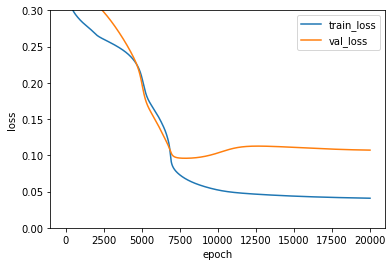

In [ ]:
#train_loss vs. val_loss 비교 
plt.plot(layer2.losses)
plt.plot(layer2.val_losses)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.3)
plt.legend(['train_loss','val_loss'])
plt.show()

- __손실 그래프가 이전보다 천천히 천천히 감소하고 있다. 그 이유는 단일 신경망보다 가중치의 수가 훨씬 많아져 학습하는 데 시간이 오래 걸리기 때문!__
- 앞서 SingleLayer 클래스에선 가중치w가 30개(피처 개수)만큼, 절편 b가 1개 있었다.->총 31개
---
- 하지만 DualLayer 클래스에선
- 은닉층:: 가중치 w가 30개(피처 개수)x10개(은닉층 뉴런개수)=300개, 절편 b가 1개x10개(은닉층 뉴런개수)=10개 --> 총 310개 필요
- 출력층:: w가 10개, b가 1개 --> 총 11개 필요, 토탈 321개 필요
- 그래서 DualLayer 클래스에선 가중치 수가 많아져 학습하는 데 시간이 오래 걸린다. 또한 디폴트로 units(은닉층 뉴런개수)=10일 때 이 정도이므로 units가 커지거나, 층을 더 많이 쌓는 경우는 더더욱 학습시간이 증가할 것임. 하지만 일반적으로 그만큼 성능이 더 좋아진다. (나중엔 출력층의 뉴런도 많아지는 케이스를 공부해보자)

In [ ]:
# 손실 그래프에서 초기 손실값이 감소하는 곡선이 매끄럽지 않음.-> 손실함수가 감소하는 방향을 올바르게 찾는 데 시간이 많이 소요됨.
#초깃값을 임의로 1로 놓고 훈련했기 때문!(가중치를 random.normal을 사용해 0~1 사이의 무작위 수로 놓고 훈련해보자.)

#DualLayer의 init_weights 메서드만 상속받아 수정.
class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features): 
        np.random.seed(42) #실습 결과와 동일하게 하기 위함(실전에선 필요x)
        self.w1 = np.random.normal(0,1,(n_features, self.units)) #(30x10)
        self.b1 = np.zeros(self.units) #(1x10)
        self.w2 = np.random.normal(0,1,(self.units, 1)) #(10x1) 출력뉴런은 반드시 1개이므로.(A2만 출력돼야 하니까)
        self.b2 = 0  #(1x1) 스칼라.

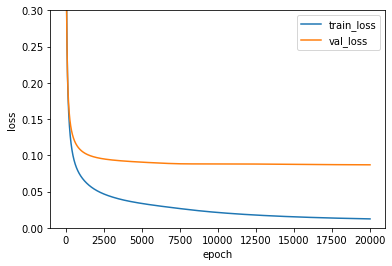

In [ ]:
#모델 훈련 다시
layer3 = RandomInitNetwork(l2=0.01)
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val=y_val, epochs=20000) 

#train_loss vs. val_loss 비교 
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.3)
plt.legend(['train_loss','val_loss'])
plt.show() #이젠 손실함수가 감소하는 첫부분이 매끄럽고, 이전보다 빠르게 손실값이 줄어들었다.(가중치를 무작위로 초기화한 게 학습 성능에도 영향o)

In [ ]:
#성능도 더 좋아짐.
layer3.score(x_val_scaled, y_val)

0.989010989010989

## 06-3. 미니 배치 경사 하강법 구현
- 앞서 한 `RandomInitNetwork`를 상속받고, batch_size부분만 수정.
- __batch_size 또한 하이퍼 파라미터임.__

In [ ]:
class MinibatchNetwork(RandomInitNetwork):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0): #batch_size는 디폴트 32
        super().__init__(units, learning_rate, l1, l2) #batch_size 제외한 나머지 부분은 그대로 받음 
        self.batch_size = batch_size 

    ## get_batch 메서드 추가 --> x,y가 들어오면 랜덤하게 batch_size만큼 x_batch, y_batch 뽑아 출력
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size #미니배치의 횟수 
        if length % self.batch_size: #나머지가 있다면 횟수 +1 
            bins +=1 
        #인덱스 랜덤 섞기
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        #미니배치 횟수만큼 실행 
        for i in range(bins):
            #인덱스 설정하여 나눠줌 
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] #x_batch, y_batch 반환. (return으로 해도 되는데 메모리 사용이 효율적인 제너레이터로 접근함.)

    #fit 메서드 수정- for epoch 내에 미니배치 만큼만 데이터를 돌리는 for문 추가!(확률적 경사하강법과 비슷하다고 생각!)
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        #타겟 열벡터 변환
        y_val = y_val.reshape(-1,1)
        self.init_weights(x.shape[1]) #n_features 값 넣고 w1,b1,w2,b2 값 초기화 
        np.random.seed(42) #실습결과와 동일함을 위해(실전에선 x)
        #epoch만큼 반복
        for i in range(epochs):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x,y): #뒤의 gen_batch 메서드에서 배치사이즈만큼의 x_batch, y_batch 꺼냄 
                #타깃 열벡터 변환 
                y_batch = y_batch.reshape(-1,1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m) #뒤의 training 메서드에서 수행(출력값: A2)
                #loss 계산(평균 loss로 반환)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) #확률적 경사하강법처럼 loss를 다 더하다가 for문 벗어나면 평균값 구해서 추가 
            self.losses.append((loss+self.reg_loss())/len(x))
            self.update_val_loss(x_val, y_val)


In [ ]:
#모델 훈련
layer4 = MinibatchNetwork(l2=0.01, batch_size=32)
layer4.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val = y_val, epochs=500)
layer4.score(x_val_scaled, y_val)

0.978021978021978

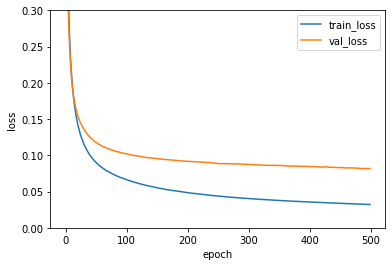

In [ ]:
#train_loss vs. val_loss 비교 
plt.plot(layer4.losses)
plt.plot(layer4.val_losses)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.3)
plt.legend(['train_loss','val_loss'])
plt.show() 

In [ ]:
#배치 크기 늘려서 수행: 32-> 128
layer5 = MinibatchNetwork(l2=0.01, batch_size=128)
layer5.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val = y_val, epochs=500)
layer5.score(x_val_scaled, y_val)

0.978021978021978

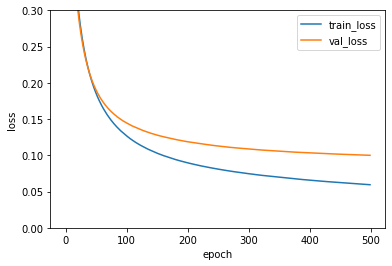

In [ ]:
#train_loss vs. val_loss 비교 
plt.plot(layer5.losses)
plt.plot(layer5.val_losses)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.3)
plt.legend(['train_loss','val_loss'])
plt.show() 

## 번외: 사이킷런 사용해 다층 신경망 훈련하기
- 사이킷런을 사용하여 앞에서 직접 구현하였던 __다층 완전 연결 신경망__을 훈련해보자. 사이킷런을 이용하면 더 간단하다!
- `sklearn.neural_network`모듈 내, __분류: `MLPClassifier`, 회귀: `MLPRegressor`를 제공__
- 여기선 cancer 데이터셋에 MLPClassifier 클래스 적용.

In [ ]:
#앞서 구현한 미니 배치 경사하강법+다중 신경망(은닉층 1개)
from sklearn.neural_network import MLPClassifier
#객체
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic',solver='sgd',            #뉴런수가 10개인 은닉층 1개 만듦. activation: logistic은 기본적으로 ReLu 적용 
                    alpha =0.01, batch_size=32, learning_rate_init=0.1, max_iter=500)      #규제는 L2 규제만 지원함.(l2=0.01), max_iter=epoch

In [ ]:
#훈련
mlp.fit(x_train_scaled, y_train)
#평가
mlp.score(x_val_scaled, y_val)

0.989010989010989